In [1]:
import pandas as pd
# from google.colab import drive
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# drive.mount('/content/drive/')

Mounted at /content/drive/


Load dataset:

In [3]:
df_stroke = pd.read_csv("../data/train_strokes.csv")

In [4]:
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


Check categorical values:

In [5]:
for col in ["gender", "hypertension", "heart_disease",
            "ever_married", "work_type", "Residence_type",
            "smoking_status"]:
  print(pd.DataFrame(df_stroke[col].value_counts(dropna=False)))
  print("")
  

        gender
Female   25665
Male     17724
Other       11

   hypertension
0         39339
1          4061

   heart_disease
0          41338
1           2062

     ever_married
Yes         27938
No          15462

               work_type
Private            24834
Self-employed       6793
children            6156
Govt_job            5440
Never_worked         177

       Residence_type
Urban           21756
Rural           21644

                 smoking_status
never smoked              16053
NaN                       13292
formerly smoked            7493
smokes                     6562



Dropping "Other" in gender column.

In [6]:
df_stroke = df_stroke.loc[df_stroke["gender"] != "Other", :]

Check missingness:

In [7]:
df_stroke.isnull().sum(axis=0) / len(df_stroke)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.033603
smoking_status       0.306299
stroke               0.000000
dtype: float64

Replace categorical values:

In [8]:
df_stroke = df_stroke.replace({'gender':{"Female":1, "Male":0},
                               'ever_married':{"Yes":1, "No":0},
                               'Residence_type':{"Urban":1, "Rural":0}})

Check for MCAR/MNAR:

In [9]:
df_stroke["bmi_missing"] = df_stroke.apply(lambda x: 1 if pd.isna(x["bmi"]) else 0, axis=1)
df_stroke["smoking_status_missing"] = df_stroke.apply(lambda x: 1 if pd.isna(x["smoking_status"]) else 0, axis=1)

for missing in ["bmi", "smoking_status"]:
  for column in ["age", "gender", "hypertension", "heart_disease",
                 "ever_married", "Residence_type", "bmi", "stroke"]:
    df_stroke_notnull = df_stroke.dropna(subset=[column])
    if missing != column:
      pval = stats.ttest_ind(df_stroke_notnull[df_stroke_notnull[missing+"_missing"] == 1][column],
                    df_stroke_notnull[df_stroke_notnull[missing+"_missing"] == 0][column]).pvalue
      sig = "" if pval <= 0.05 else "not"
      print("{} is {} significantly associated with missing {} (pval = {})".format(column, sig, missing, pval))

age is  significantly associated with missing bmi (pval = 6.841188546025313e-79)
gender is  significantly associated with missing bmi (pval = 1.1529690718875273e-14)
hypertension is  significantly associated with missing bmi (pval = 1.2575698343044928e-120)
heart_disease is  significantly associated with missing bmi (pval = 4.560161586284766e-119)
ever_married is  significantly associated with missing bmi (pval = 1.5191827842372512e-32)
Residence_type is not significantly associated with missing bmi (pval = 0.30880814667517464)
stroke is  significantly associated with missing bmi (pval = 2.908411697384368e-115)
age is  significantly associated with missing smoking_status (pval = 0.0)
gender is  significantly associated with missing smoking_status (pval = 9.293361833490132e-33)
hypertension is  significantly associated with missing smoking_status (pval = 1.3880324482587923e-143)
heart_disease is  significantly associated with missing smoking_status (pval = 7.3390141130896986e-34)
ever_m

These p-values seem very low, wondering if I should use a different test? Try with chi-square test instead:

In [10]:
for missing in ["bmi", "smoking_status"]:
  for column in ["age", "gender", "hypertension", "heart_disease",
                 "ever_married", "Residence_type", "bmi", "stroke"]:
    df_stroke_notnull = df_stroke.dropna(subset=[column])
    if missing != column:
      crosstab = pd.crosstab(df_stroke_notnull[missing+"_missing"], df_stroke_notnull[column])
      pval = stats.chi2_contingency(crosstab)[1]
      sig = "" if pval <= 0.05 else "not"
      print("{} is {} significantly associated with missing {} (pval = {})".format(column, sig, missing, pval))

age is  significantly associated with missing bmi (pval = 9.349008497126374e-68)
gender is  significantly associated with missing bmi (pval = 1.452959413614487e-14)
hypertension is  significantly associated with missing bmi (pval = 1.9869620382542014e-119)
heart_disease is  significantly associated with missing bmi (pval = 1.0111072993421801e-117)
ever_married is  significantly associated with missing bmi (pval = 2.36693803985193e-32)
Residence_type is not significantly associated with missing bmi (pval = 0.3216325166689927)
stroke is  significantly associated with missing bmi (pval = 1.3269609448338936e-113)
age is  significantly associated with missing smoking_status (pval = 0.0)
gender is  significantly associated with missing smoking_status (pval = 1.1813020489809205e-32)
hypertension is  significantly associated with missing smoking_status (pval = 2.447017703553832e-142)
heart_disease is  significantly associated with missing smoking_status (pval = 1.1164308374032304e-33)
ever_mar

Same result, need to look into the issue...
Age makes sense for correlation with smoking data (probably don't ask very young children if they smoke, can maybe replace with non-smokers?)

                              age
smoking_status_missing           
Missing                 29.264153
Not missing             47.940197


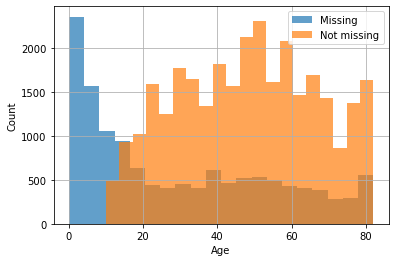

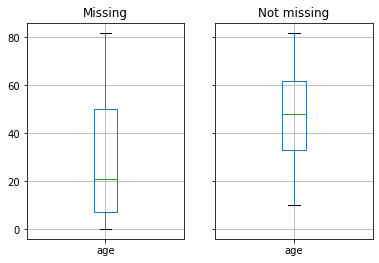

In [21]:
print(pd.DataFrame(df_stroke.groupby('smoking_status_missing')['age'].mean()))
df_stroke.loc[df_stroke['smoking_status_missing'] == 0, "smoking_status_missing"] = "Not missing"
df_stroke.loc[df_stroke['smoking_status_missing'] == 1, "smoking_status_missing"] = "Missing"
df_stroke.groupby('smoking_status_missing')['age'].hist(alpha=0.7, legend=True, bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig("missing_smoking.jpg", dpi=300)
plt.show()
df_stroke.groupby('smoking_status_missing').boxplot(column="age")
plt.savefig("missing_smoking_boxplot.jpg", dpi=300)
plt.show()

In [ ]:
df_stroke_modified = df_stroke.copy()
df_stroke_modified.loc[(df_stroke["age"] < 15) & pd.isna(df_stroke["smoking_status"]), "smoking_status"] = "never smoked"

In [ ]:
df_stroke_modified.isnull().sum(axis=0) / len(df_stroke_modified)

id                        0.000000
gender                    0.000000
age                       0.000000
hypertension              0.000000
heart_disease             0.000000
ever_married              0.000000
work_type                 0.000000
Residence_type            0.000000
avg_glucose_level         0.000000
bmi                       0.033603
smoking_status            0.179562
stroke                    0.000000
bmi_missing               0.000000
smoking_status_missing    0.000000
dtype: float64

In [ ]:
df_stroke.loc[(df_stroke["smoking_status"] == "smokes") & (df_stroke["age"] < 15), :]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_missing,smoking_status_missing
831,42821,1,13.0,0,0,0,Private,0,60.69,24.0,smokes,0,0,0
1285,4833,1,12.0,0,0,0,children,0,207.45,25.4,smokes,0,0,0
1795,64128,0,10.0,0,0,0,children,1,63.08,20.5,smokes,0,0,0
12053,46934,0,14.0,0,0,0,Private,1,121.58,19.6,smokes,0,0,0
13934,44072,1,14.0,0,0,0,Private,0,64.69,22.2,smokes,0,0,0
15371,63106,1,14.0,0,0,0,Private,1,121.77,30.8,smokes,0,0,0
24232,39989,0,14.0,0,0,0,children,0,128.50,22.9,smokes,0,0,0
28341,20401,1,11.0,0,0,0,children,0,85.08,20.1,smokes,0,0,0
28626,22391,0,13.0,0,0,0,Private,0,87.79,33.9,smokes,0,0,0
28740,15077,0,12.0,0,0,0,children,1,109.79,29.9,smokes,0,0,0


In [ ]:
df_stroke.loc[df_stroke["age"] < 15, :]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_missing,smoking_status_missing
0,30669,0,3.0,0,0,0,children,0,95.12,18.0,NaN,0,0,1
2,16523,1,8.0,0,0,0,Private,1,110.89,17.6,NaN,0,0,1
4,46136,0,14.0,0,0,0,Never_worked,0,161.28,19.1,NaN,0,0,1
33,33759,1,3.0,0,0,0,children,1,73.74,16.0,NaN,0,0,1
35,26325,0,14.0,0,0,0,Govt_job,1,82.34,31.6,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43376,65913,1,3.0,0,0,0,children,0,83.32,21.3,NaN,0,0,1
43382,35179,1,9.0,0,0,0,children,1,68.49,16.8,NaN,0,0,1
43389,30759,0,14.0,0,0,0,children,1,82.48,24.8,NaN,0,0,1
43391,30077,0,6.0,0,0,0,children,1,77.48,19.1,NaN,0,0,1


In [ ]:
df_stroke_modified["bmi_missing"] = df_stroke_modified.apply(lambda x: 1 if pd.isna(x["bmi"]) else 0, axis=1)
df_stroke_modified["smoking_status_missing"] = df_stroke_modified.apply(lambda x: 1 if pd.isna(x["smoking_status"]) else 0, axis=1)

for missing in ["bmi", "smoking_status"]:
  for column in ["age", "gender", "hypertension", "heart_disease",
                 "ever_married", "Residence_type", "bmi", "stroke"]:
    df_stroke_notnull = df_stroke_modified.dropna(subset=[column])
    if missing != column:
      crosstab = pd.crosstab(df_stroke_notnull[missing+"_missing"], df_stroke_notnull[column])
      pval = stats.chi2_contingency(crosstab)[1]
      sig = "" if pval <= 0.05 else "not"
      print("{} is {} significantly associated with missing {} (pval = {})".format(column, sig, missing, pval))

age is  significantly associated with missing bmi (pval = 9.349008497126374e-68)
gender is  significantly associated with missing bmi (pval = 1.452959413614487e-14)
hypertension is  significantly associated with missing bmi (pval = 1.9869620382542014e-119)
heart_disease is  significantly associated with missing bmi (pval = 1.0111072993421801e-117)
ever_married is  significantly associated with missing bmi (pval = 2.36693803985193e-32)
Residence_type is not significantly associated with missing bmi (pval = 0.3216325166689927)
stroke is  significantly associated with missing bmi (pval = 1.3269609448338936e-113)
age is  significantly associated with missing smoking_status (pval = 0.0)
gender is not significantly associated with missing smoking_status (pval = 0.20282185396157212)
hypertension is  significantly associated with missing smoking_status (pval = 2.0694255052816236e-17)
heart_disease is not significantly associated with missing smoking_status (pval = 0.5868248733122423)
ever_marr

Clustering analysis: